In [1]:
import pandas as pd
import numpy as np
from scipy.stats._continuous_distns import _distn_names
import scipy.stats as st
import matplotlib.pyplot as plt
import warnings

# Data generation

In [2]:
N = 1000 # number of samples
columns = ['A-E', 'F-J', 'K-O', 'P-T', 'U-Z']

X = np.zeros((N, len(columns))) # initialize matrix

# dataset 1
lam = 0.5
X[:, 0] = np.random.exponential(scale=1/lam, size=N)
# dataset 2
k  = 2
scale = 3
X[:, 1] = np.random.weibull(k, N) * scale
# dataset 3
alpha = 5
beta = 2
loc = -1
scale = 1
X[:, 2] = np.random.beta(alpha, beta, N) * scale + loc
# dataset 4
alpha = 2
beta = 5
loc = 1
scale = 1
X[:, 3] = np.random.beta(alpha, beta, N) * scale + loc
# dataset 5
left = 0
mode = 2
right = 3
X[:, 4] = np.random.triangular(left, mode, right, N)

# create dataframe
df = pd.DataFrame(X)
df.columns = columns
df.head()

,A-E,F-J,K-O,P-T,U-Z
0,0.547747,3.172922,-0.191183,1.131322,0.636366
1,0.717403,1.407737,-0.316613,1.232231,0.728358
2,2.794572,2.632436,-0.079000,1.289065,2.555058
3,5.004638,0.966927,-0.092700,1.108173,2.676776
4,1.212874,1.145074,-0.023325,1.127315,1.972880


In [3]:
# Save data as csv file
df.to_csv('data.csv', index=False)

# Problem description

Input data analysis is crucial in order to build valid simulation models. This assignment is inspired by a real-world problem in the production line of a major truck manufacturing company in Sweden.

Assume that you are a supply chain engineer who has been asked to optimize a particular supply chain system. You decide to approach this problem using FACTS for building a model of the system and run a simulation-based optimization. Now you are trying to model the processing time of a particular operation. You are provided with a dataset of historical data of the operation. You want to represent the processing time as a random distribution, but you don't have any prior knowledge of the distribution type. Therefore, you need to fit the data to different probability distributions and find the distribution that better represents your data so you can use it in your simulation model.

You can solve this problem using Python. A Jupyter Notebook will allow you to visualize the output for each step. If you don't want to install any software you can use Google Colab. You are also allowed to use other programming languages!

# Part 1 - Hypothesis

You will start getting some information from the data in order to make an initial guess of its distribution.

Step 1) Load the data (hint: load the data as a NumPy array or as a pandas DataFrame).

You can download the data here. There are 5 columns belonging to 5 different distributions. You will work with the column that includes the initial letter of your name. 

Step 2) Plot the data (give a thought on what type of plot you should use).

Step 3) Compute some statistics:

- Minimum
- Maximum
- Average
- Standard deviation
- Median
- First quartile (Q1)
- Third quartile (Q3)
- Interquartile range (IQR)
- Mode (hint: group the data into bins)
- Skewness

Make sure you understand all statistical concepts!

Step 4) Justify an initial guess of the distribution and its parameters.

In [4]:
# Load data
df = pd.read_csv('data.csv')
data = df["F-J"]

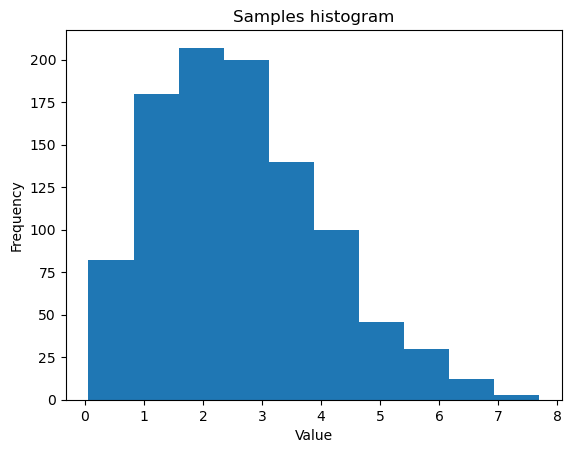

In [5]:
plt.hist(data)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Samples histogram")
plt.show()

In [6]:
print(f'Min value: {min(data)}')
print(f'Max value: {max(data)}')
print(f'Average: {np.mean (data)}')
print(f'Median: {np.median(data)}')
q1, q3 = np.percentile(data, [25, 75])
iqr = q3 - q1
print("Q1:", q1)
print("Q3:", q3)
print("IQR:", iqr)
y, x = np.histogram(data)
mode_bin = np.argmax(y)
mode = (x[mode_bin] + x[mode_bin+1])/2
print(f'Mode: {mode}')
print(f'Standard deviation: {np.std(data)}')
print(f'Skewness: {st.skew(data)}')

Min value: 0.0615293853956771
Max value: 7.693563608564713
Average: 2.620390674052434
Median: 2.4542276741483517
Q1: 1.5253614566000284
Q3: 3.521227161704368
IQR: 1.9958657051043394
Mode: 1.9695379411879363
Standard deviation: 1.4076885192595145
Skewness: 0.6012374537840766


# Part 2 - Fit distributions

## Part 2.1

Step 1) Decide a set of distribution families to try fitting your data.

Step 2) Define a dictionary which has as keys the name of the distributions and as values the distribution objects (hint: use SciPy to import the distributions).

In [7]:
# Check distributions name in scipy.stats
#_distn_names

In [8]:
distributions_dict = {
    'Triang': getattr(st, 'triang'),
    'Exponential': getattr(st, 'expon'),
    'Uniform': getattr(st, 'uniform'),
    'Normal': getattr(st, 'norm'),
    'LogNormal': getattr(st, 'lognorm'),
    'Beta': getattr(st, 'beta'),
    'Gamma': getattr(st, 'gamma'),
    'Weibull': getattr(st, 'weibull_min'),    
}

## Part 2.2

Now you will define a function that receives as input the data and the distributions dictionary (you can add additional inputs) and that plots the data with the curves for all Probability Distribution Functions (PDFs) in one figure and returns the distribution that better fits the data and its parameters.

Step 1) Group the data into bins and find their densities (hint: create a histogram using NumPy).

Step 2) Find the midpoints of the bins.

Step 3) Create a loop where in each iteration you can access one distribution.

Step 3.1) Find the best parameters of the distribution given your data.

Step 3.2) Find the PDF of the distribution given the bins and the parameters.

Step 3.3) Compute the Sum of Squared Errors (SSE) between the real densities of the data grouped by bins and the pdf of the distribution.

Step 4) Find and report the best distribution and its parameters based on the lowest SSE.

Step 5) Plot all hypothesized distributions on the histogram plot of the data.

In [9]:
def fit_distributions(data, distributions_dict, bins):
    
    warnings.filterwarnings("ignore")

    best_distribution = None
    best_params = None
    best_sse = np.inf
    
    # plot data
    plt.hist(data, bins=bins, density=True, alpha=0.5, label='Data')
    dataXLim = plt.xlim()
    dataYLim = plt.ylim()
    
    # get bins
    y, x = np.histogram(data, bins=bins, density=True) # y: density values, x: bins edges
    x_mids = (x[1:] + x[:-1]) / 2 # get midpoints of the bins

    for dist_name in distributions_dict:
        distribution = distributions_dict[dist_name]
        params = distribution.fit(data) # find best parameters given a distribution
        pdf = distribution.pdf(x_mids, *params) # get density values of the pdf
        sse = np.sum((pdf - y)**2) # compute sse given the data and the pdf
        
        # plot pdf
        plt.plot(x_mids, pdf, label=dist_name)

        if sse < best_sse:
            best_distribution = dist_name, distribution
            best_params = params
            best_sse = sse
            
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Fit distributions')
    plt.xlim(dataXLim)
    plt.ylim(dataYLim)
    plt.legend()
    plt.show()
    
    param_names = (best_distribution[1].shapes + ', loc, scale').split(', ') if best_distribution[1].shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_params)])

    print(f'Best distribution: {best_distribution[0]} ({param_str})')

Step 6) Apply the function to your data and briefly discuss the reliability of your result.

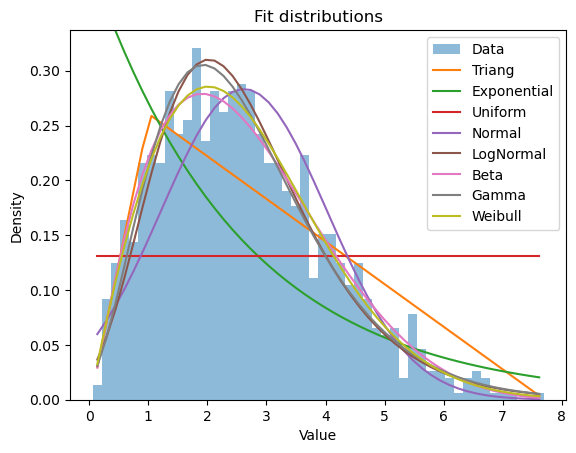

Best distribution: Weibull (c=1.92, loc=0.03, scale=2.92)


In [10]:
fit_distributions(data, distributions_dict, bins=50)

# Submission

Submit your notebook file or your code file (e.g. Python file, Matlab file, R file) and a pdf file with the outputs (plots and prints) and text.

Make sure that your script file is properly structured and commented that each step is clearly defined and presented. 

- The file including the solution should be named after the students’ surnames, i.e.: Andersson_Tomas.ipynb or Andersson_Tomas.py + Andersson_Tomas.pdf 